<a href="https://colab.research.google.com/github/ris27hav/devrevs_domain_specific_qa/blob/main/DevRev_Passage_Retrieval_Experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data

### Load Train Dataset

In [ ]:
import csv
import requests

# load training dataset
def load_data():
    CSV_URL = 'https://drive.google.com/u/0/uc?id=1Z-yb752A3o7b9dqrGt24XU0sl53FVqya&export=download'

    with requests.Session() as s:
        download = s.get(CSV_URL)
        decoded_content = download.content.decode('utf-8')
        cr = csv.reader(decoded_content.splitlines(), delimiter=',')
        train_data = list(cr)

    print(f"Number of examples = {len(train_data)}")
    ans, noans = 0, 0
    for x in train_data:
        if x[4] == 'False':
            noans += 1
        else:
            ans += 1
    print(f"\tAnswerable questions = {ans}")
    print(f"\tNon-Answerable questions = {noans}\n")
    print("Examples:")
    for i in [0, 1000, 1300]:
        print(' | '.join(train_data[i][:2]), ' | ', train_data[i][2][:20] + '...', ' | ', ' | '.join(train_data[i][3:]))
    return train_data

In [ ]:
def load_theme_wise_data(train_data):
    theme_wise_data = {}
    for x in train_data[1:]:
        if x[1] not in theme_wise_data:
            theme_wise_data[x[1]] = {
                'para': [],
                'ques': [],
                'ans': []
            }
        if x[2] not in theme_wise_data[x[1]]['para']:
            theme_wise_data[x[1]]['para'].append(x[2])
        theme_wise_data[x[1]]['ques'].append(x[3])
        # ans contains a list -> [Para_Number, Answer_possible, Answer_text, Answer_start]
        theme_wise_data[x[1]]['ans'].append([theme_wise_data[x[1]]['para'].index(x[2])] + x[4:])
    print(f'\nTotal {len(theme_wise_data)} themes present.')
    return theme_wise_data

In [ ]:
def load_ques_by_theme(theme, theme_wise_data, answerable_only = False):
    paras = theme_wise_data[theme]['para']
    ques = []
    gold_para = []
    ans = []
    for i in range(len(theme_wise_data[theme]['ques'])):
        if answerable_only and theme_wise_data[theme]['ans'][i][1] == 'False':
            continue
        ques.append(theme_wise_data[theme]['ques'][i])
        gold_para.append(theme_wise_data[theme]['ans'][i][0])
        ans.append(theme_wise_data[theme]['ans'][i][1:])

    print("Total Questions:", len(ques))
    print("Total Paragraphs:", len(paras))
    return paras, ques, gold_para, ans

### Load Test Dataset

In [ ]:
# Load Test Dataset Round 1
!gdown 15WPYOD3ZLShFq_NRtiBHbpz3RTvc8ZWR
!gdown 15yxIF27NvEa3l12yNy6F5h8lGCJ2n7rf
!gdown 1Ilpxyj_0T-1KzQMdVSEbSmc1ybxOv69G
!gdown 1nkEDQZJY6_cAEVw3JlaKCgz0C6mDSYiv

Downloading...
From: https://drive.google.com/uc?id=15WPYOD3ZLShFq_NRtiBHbpz3RTvc8ZWR
To: /content/ground_truth.csv
100% 1.35M/1.35M [00:00<00:00, 196MB/s]
Downloading...
From: https://drive.google.com/uc?id=15yxIF27NvEa3l12yNy6F5h8lGCJ2n7rf
To: /content/input_question.csv
100% 2.89M/2.89M [00:00<00:00, 235MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ilpxyj_0T-1KzQMdVSEbSmc1ybxOv69G
To: /content/theme_interval.csv
100% 3.21k/3.21k [00:00<00:00, 9.20MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nkEDQZJY6_cAEVw3JlaKCgz0C6mDSYiv
To: /content/input_paragraph.csv
100% 3.45M/3.45M [00:00<00:00, 267MB/s]


In [ ]:
# # Load Test Dataset Round 2
# !gdown 1-3fMldkBVsTAX3W5JewdAdlUG_agexG0
# !gdown 1-59pQe8TH7UaORF1RSqzFWybMJShdf1U
# !gdown 1-AbnJRRHQiTU5zyUdDC2gUwbIGkEF5l6
# !gdown 1-Px6FFj043L7lbAEBOAMSy2bdoPiVNhy

## Task 1: Paragraph Retrieval

### Common Pipeline

In [ ]:
!pip install transformers faiss-cpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 16.0 MB/s eta 0:00:00


In [ ]:
from nltk import sent_tokenize
from transformers import AutoModel, AutoTokenizer

import faiss
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
import tensorflow_hub as hub
import torch

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def para_to_sentences(para):
    """Splits a para into sentences."""
    para = para.replace('\n', ' ').replace('\t', ' ').replace('\x00', ' ')
    return sent_tokenize(para)

def load_sents_from_para(paras):
    sents = []
    para_id = []
    for id, x in enumerate(paras):
        new_sents = para_to_sentences(x)
        sents += new_sents
        para_id += [id]*len(new_sents)
    return sents, para_id

In [ ]:
def load_encoder(encoder):
    if encoder == 'Universal Sentence Encoder':
        module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
        model = hub.load(module_url)
        return _, model
    elif encoder == "Universal Sentence Encoder for QA":
        module_url = "https://tfhub.dev/google/universal-sentence-encoder-qa/3"
        model = hub.load(module_url)
        return _, model
    elif encoder == 'SimCSE':
        tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/sup-simcse-bert-base-uncased")
        model = AutoModel.from_pretrained("princeton-nlp/sup-simcse-bert-base-uncased")
        return tokenizer, model
    else:
        print("Encoder not found. Please choose one from - 1. Universal Sentence Encoder, 2. Universal Sentence Encoder for QA, 3. SimCSE")


def get_embeddings(sents, encoder, tokenizer, model, sents_type="default"):
    if encoder == 'Universal Sentence Encoder':
        return model(sents)
    elif encoder == 'Universal Sentence Encoder for QA':
        if sents_type == "Question":
            return model.signatures['question_encoder'](tf.constant(sents))['outputs']
        return model.signatures['response_encoder'](
            input = tf.constant(sents),
            context = tf.constant(sents)
        )['outputs']
    elif encoder == 'SimCSE':
        tokens = tokenizer(sents, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            embeds = model(**tokens, output_hidden_states=True, return_dict=True).pooler_output
        return embeds
    print("Encoder not found. Please choose one from - 1. Universal Sentence Encoder, 2. Universal Sentence Encoder for QA, 3. SimCSE")

In [ ]:
def get_k_nearest_neighbours(sents_embed, ques_embed, k = 10):
    index = faiss.IndexFlatL2(sents_embed.shape[1])
    index.add(sents_embed)
    return index.search(ques_embed, k)

def sent_id_to_para_id(I, para_id):
    return [[para_id[sent_idx] for sent_idx in I[i]] for i in range(len(I))]

In [ ]:
def print_example(i, sents, ques, pred_para, I, D):
    cur_ques = ques[i]
    print('question:', cur_ques)
    print('similar sentences:')
    print('\tTarget sentence | Predicted Para ID | Distance between target sentence and query')
    for j in range(D.shape[1]):
        target_sent = sents[I[i,j]]
        print('\t', target_sent, '|', pred_para[i][j], '|', D[i, j])

In [ ]:
def getRank(pred, gold):
    i = 1
    for p in pred:
        if p == gold:
            return i
        i += 1
    return i

# Mean Rank of most relevant passage
def getMeanRank(preds, gold):
    k = len(preds[0])
    rankSum = 0
    notInTopK = 0
    for i, g in zip(preds, gold):
        rank = getRank(i, g)
        if rank > k:
            notInTopK += 1
        else:
            rankSum += rank
    avg = k+1
    if len(gold) > notInTopK:
        avg = rankSum / (len(gold) - notInTopK)
    return notInTopK, avg


# Histogram of ranks of the most relevant passage
def showHistogram(preds, gold):
    k = len(preds[0])
    ranks = []
    for i, g in zip(preds, gold):
        rank = getRank(i, g)
        if rank <= k:
            ranks.append(rank)
    plt.hist(ranks)
    plt.xlabel("Rank of the most relevant passage")
    plt.ylabel("Count")
    plt.show()

In [ ]:
def evaluate_results(pred_para, gold_para):
    notInTopK, meanRank = getMeanRank(pred_para, gold_para)
    print("Total queries:", len(pred_para))
    print(f"In top {len(pred_para[0])} results, number of queries for which -")
    print(f"\tRelevant paragraph found: {len(pred_para) - notInTopK} ({100 - round(100.*notInTopK / len(pred_para))} %)")
    print(f"\tRelevant paragraph NOT found: {notInTopK} ({round(100.*notInTopK / len(pred_para))} %)")
    print(f"Mean Rank for which relevant paragraph found: {round(meanRank, 2)}\n")

    showHistogram(pred_para, gold_para)

### Approach 1: Breaking passage into sentences -> sentence embeddings

#### 1. Using Google's Universal Sentence Encoder Large

In [ ]:
train_data = load_data()
theme_wise_data = load_theme_wise_data(train_data)

Number of examples = 75056
	Answerable questions = 50126
	Non-Answerable questions = 24930

Examples:
 | Theme  |  Paragraph...  |  Question | Answer_possible | Answer_text | Answer_start
1430 | Frédéric_Chopin  |  Some modern commenta...  |  Who said Chopin's works were modeled after Bach, Beethoven, Schubert and Field? | True | ['Richard Taruskin'] | [543]
2196 | The_Legend_of_Zelda:_Twilight_Princess  |  Twilight Princess ta...  |  Who releases Bulbins from the Realm of Twilight? | False | [] | []

Total 361 themes present.


In [ ]:
# Retrieving sentences for one theme

paras, ques, gold_para, _ = load_ques_by_theme('Beyoncé', theme_wise_data, answerable_only=True)
sents, para_id = load_sents_from_para(paras)

Total Questions: 523
Total Paragraphs: 66


In [ ]:
encoder = 'Universal Sentence Encoder'
_, model = load_encoder(encoder)

In [ ]:
k = 10
sents_embed = get_embeddings(sents, encoder, _, model)
ques_embed = get_embeddings(ques, encoder, _, model)
D, I = get_k_nearest_neighbours(sents_embed, ques_embed, k)
pred_para = sent_id_to_para_id(I, para_id)

In [ ]:
print_example(0, sents, ques, pred_para, I, D)

question: When did Beyonce leave Destiny's Child and become a solo singer?
similar sentences:
	Target sentence | Predicted Para ID | Distance between target sentence and query
	 Following the disbandment of Destiny's Child in June 2005, she released her second solo album, B'Day (2006), which contained hits "Déjà Vu", "Irreplaceable", and "Beautiful Liar". | 1 | 0.6500025
	 As a solo artist she has sold over 15 million albums in the US, and over 118 million records worldwide (a further 60 million additionally with Destiny's Child), making her one of the best-selling music artists of all time. | 53 | 0.79914117
	 Throughout a career spanning 19 years, she has sold over 118 million records as a solo artist, and a further 60 million with Destiny's Child, making her one of the best-selling music artists of all time. | 2 | 0.80471325
	 In early 2001, while Destiny's Child was completing their third album, Beyoncé landed a major role in the MTV made-for-television film, Carmen: A Hip Hopera, 

Total queries: 523
In top 10 results, number of queries for which -
	Relevant paragraph found: 449 (86 %)
	Relevant paragraph NOT found: 74 (14 %)
Mean Rank for which relevant paragraph found: 2.11



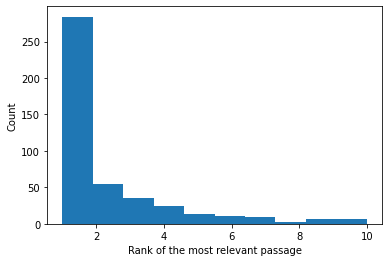

In [ ]:
evaluate_results(pred_para, gold_para)

In [ ]:
# Retrieving sentences for all themes

k = 10
numThemes = len(theme_wise_data.keys())
total = 0
notInTopKSum = 0
rankSum = 0.
i = 0

for theme in theme_wise_data:
    paras, ques, gold_para, _ = load_ques_by_theme(theme, theme_wise_data, answerable_only=True)
    sents, para_id = load_sents_from_para(paras)

    sents_embed = model(sents)
    ques_embed = model(ques)

    D, I = get_k_nearest_neighbours(sents_embed, ques_embed, k)
    pred_para = sent_id_to_para_id(I, para_id)

    notInTopK, avg = getMeanRank(pred_para, gold_para)
    total += len(ques)
    notInTopKSum += notInTopK
    rankSum += avg * (len(ques) - notInTopK)

    i += 1
    print(f'\r{i}/{numThemes} themes evaluated', end='')

In [ ]:
inTopKSum = total - notInTopKSum
print(f"Total queries: {total}")
print(f"In top {k} results, number of queries for which -")
print(f"\tRelevant paragraph found: {inTopKSum} ({round(100.*inTopKSum / total, 2)} %)")
print(f"\tRelevant paragraph NOT found: {notInTopKSum} ({round(100.*notInTopKSum / total, 2)} %)")
print(f"Mean Rank for which relevant paragraph found: {round(rankSum / total, 2)}")

Total queries: 50125
In top 10 results, number of queries for which -
	Relevant paragraph found: 46954 (93.67 %)
	Relevant paragraph NOT found: 3171 (6.33 %)
Mean Rank for which relevant paragraph found: 1.6


In [ ]:
# 38 mins 05 secs for 50126 queries consisting of 361 themes

#### 2. Using Google's Universal Sentence Encoder for QA

In [ ]:
train_data = load_data()
theme_wise_data = load_theme_wise_data(train_data)

Number of examples = 75056
	Answerable questions = 50126
	Non-Answerable questions = 24930

Examples:
 | Theme  |  Paragraph...  |  Question | Answer_possible | Answer_text | Answer_start
1430 | Frédéric_Chopin  |  Some modern commenta...  |  Who said Chopin's works were modeled after Bach, Beethoven, Schubert and Field? | True | ['Richard Taruskin'] | [543]
2196 | The_Legend_of_Zelda:_Twilight_Princess  |  Twilight Princess ta...  |  Who releases Bulbins from the Realm of Twilight? | False | [] | []

Total 361 themes present.


In [ ]:
# Retrieving sentences for one theme

paras, ques, gold_para, _ = load_ques_by_theme('Beyoncé', theme_wise_data, answerable_only=True)
sents, para_id = load_sents_from_para(paras)

Total Questions: 523
Total Paragraphs: 66


In [ ]:
encoder = 'Universal Sentence Encoder for QA'
_, model = load_encoder(encoder)

In [ ]:
k = 10
sents_embed = get_embeddings(sents, encoder, _, model, sents_type="Context")
ques_embed = get_embeddings(ques, encoder, _, model, sents_type="Question")
D, I = get_k_nearest_neighbours(sents_embed, ques_embed, k)
pred_para = sent_id_to_para_id(I, para_id)

In [ ]:
print_example(0, sents, ques, pred_para, I, D)

question: When did Beyonce leave Destiny's Child and become a solo singer?
similar sentences:
	Target sentence | Predicted Para ID | Distance between target sentence and query
	 Following the disbandment of Destiny's Child in June 2005, she released her second solo album, B'Day (2006), which contained hits "Déjà Vu", "Irreplaceable", and "Beautiful Liar". | 1 | 0.753831
	 She has received co-writing credits for most of the songs recorded with Destiny's Child and her solo efforts. | 36 | 0.86313295
	 Throughout a career spanning 19 years, she has sold over 118 million records as a solo artist, and a further 60 million with Destiny's Child, making her one of the best-selling music artists of all time. | 2 | 0.86395407
	 However, this was put on hold so she could concentrate on recording Destiny Fulfilled, the final studio album by Destiny's Child. | 11 | 0.87941134
	 Destiny's Child embarked on a worldwide concert tour, Destiny Fulfilled... and Lovin' It and during the last stop of their

Total queries: 523
In top 10 results, number of queries for which -
	Relevant paragraph found: 449 (86 %)
	Relevant paragraph NOT found: 74 (14 %)
Mean Rank for which relevant paragraph found: 2.11



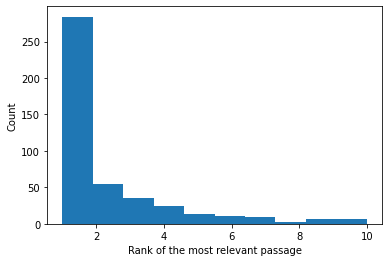

In [ ]:
evaluate_results(pred_para, gold_para) # without Universal Sentence Encoder for QA

Total queries: 523
In top 10 results, number of queries for which -
	Relevant paragraph found: 469 (90 %)
	Relevant paragraph NOT found: 54 (10 %)
Mean Rank for which relevant paragraph found: 1.97



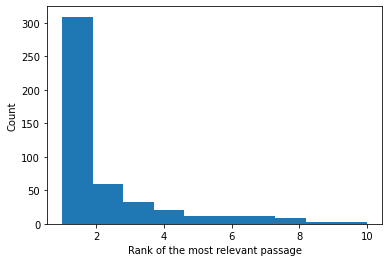

In [ ]:
evaluate_results(pred_para, gold_para) # with Universal Sentence Encoder for QA

In [ ]:
# Retrieving sentences for all themes

k = 10
encoder = 'Universal Sentence Encoder for QA'
_, model = load_encoder(encoder)
numThemes = len(theme_wise_data.keys())
total = 0
notInTopKSum = 0
rankSum = 0.
i = 0


for theme in theme_wise_data:
    paras, ques, gold_para, _ = load_ques_by_theme(theme, theme_wise_data, answerable_only=True)
    sents, para_id = load_sents_from_para(paras)

    sents_embed = get_embeddings(sents, encoder, _, model, sents_type="Context")
    ques_embed = get_embeddings(ques, encoder, _, model, sents_type="Question")

    D, I = get_k_nearest_neighbours(sents_embed, ques_embed, k)
    pred_para = sent_id_to_para_id(I, para_id)

    notInTopK, avg = getMeanRank(pred_para, gold_para)
    total += len(ques)
    notInTopKSum += notInTopK
    rankSum += avg * (len(ques) - notInTopK)

    i += 1
    print(f'\r{i}/{numThemes} themes evaluated', end='')

In [ ]:
inTopKSum = total - notInTopKSum
print(f"Total queries: {total}")
print(f"In top {k} results, number of queries for which -")
print(f"\tRelevant paragraph found: {inTopKSum} ({round(100.*inTopKSum / total, 2)} %)")
print(f"\tRelevant paragraph NOT found: {notInTopKSum} ({round(100.*notInTopKSum / total, 2)} %)")
print(f"Mean Rank for which relevant paragraph found: {round(rankSum / total, 2)}")

Total queries: 50125
In top 10 results, number of queries for which -
	Relevant paragraph found: 47511 (94.79 %)
	Relevant paragraph NOT found: 2614 (5.21 %)
Mean Rank for which relevant paragraph found: 1.55


In [ ]:
# 36 mins 12 secs for 50126 queries consisting of 361 themes (including time for embedding paragraphs)

#### 3. Using SimCSE

In [ ]:
train_data = load_data()
theme_wise_data = load_theme_wise_data(train_data)

Number of examples = 75056
	Answerable questions = 50126
	Non-Answerable questions = 24930

Examples:
 | Theme  |  Paragraph...  |  Question | Answer_possible | Answer_text | Answer_start
1430 | Frédéric_Chopin  |  Some modern commenta...  |  Who said Chopin's works were modeled after Bach, Beethoven, Schubert and Field? | True | ['Richard Taruskin'] | [543]
2196 | The_Legend_of_Zelda:_Twilight_Princess  |  Twilight Princess ta...  |  Who releases Bulbins from the Realm of Twilight? | False | [] | []

Total 361 themes present.


In [ ]:
# Retrieving sentences for one theme

paras, ques, gold_para, _ = load_ques_by_theme('Beyoncé', theme_wise_data, answerable_only=True)
sents, para_id = load_sents_from_para(paras)

Total Questions: 523
Total Paragraphs: 66


In [ ]:
encoder = 'SimCSE'
tokenizer, model = load_encoder(encoder)

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/689 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
k = 10
sents_embed = get_embeddings(sents, encoder, tokenizer, model)
ques_embed = get_embeddings(ques, encoder, tokenizer, model)
D, I = get_k_nearest_neighbours(sents_embed, ques_embed, k)
pred_para = sent_id_to_para_id(I, para_id)

In [ ]:
print_example(0, sents, ques, pred_para, I, D)

question: When did Beyonce leave Destiny's Child and become a solo singer?
similar sentences:
	Target sentence | Predicted Para ID | Distance between target sentence and query
	 After the release of Dangerously in Love, Beyoncé had planned to produce a follow-up album using several of the left-over tracks. | 11 | 23.658646
	 When The Guardian named her Artist of the Decade, Llewyn-Smith wrote, "Why Beyoncé? | 50 | 24.23243
	 In February 2013, Beyoncé said that Madonna inspired her to take control of her own career. | 40 | 25.370155
	 In early 2001, while Destiny's Child was completing their third album, Beyoncé landed a major role in the MTV made-for-television film, Carmen: A Hip Hopera, starring alongside American actor Mekhi Phifer. | 8 | 25.500847
	 Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Ba

Total queries: 523
In top 10 results, number of queries for which -
	Relevant paragraph found: 447 (85 %)
	Relevant paragraph NOT found: 76 (15 %)
Mean Rank for which relevant paragraph found: 2.24



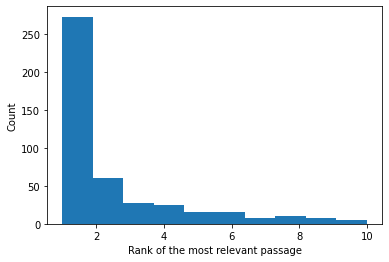

In [ ]:
evaluate_results(pred_para, gold_para)

In [ ]:
# Retrieving sentences for all themes

k = 10
numThemes = len(theme_wise_data.keys())
total = 0
notInTopKSum = 0
rankSum = 0.
i = 0

for theme in theme_wise_data:
    paras, ques, gold_para, _ = load_ques_by_theme(theme, theme_wise_data, answerable_only=True)
    sents, para_id = load_sents_from_para(paras)

    sents_tok = tokenizer(sents, padding=True, truncation=True, return_tensors="pt")
    ques_tok = tokenizer(ques, padding=True, truncation=True, return_tensors="pt")

    with torch.no_grad():
        sents_embed = model(**sents_tok, output_hidden_states=True, return_dict=True).pooler_output
        ques_embed = model(**ques_tok, output_hidden_states=True, return_dict=True).pooler_output

    D, I = get_k_nearest_neighbours(sents_embed, ques_embed, k)
    pred_para = sent_id_to_para_id(I, para_id)

    notInTopK, avg = getMeanRank(pred_para, gold_para)
    total += len(ques)
    notInTopKSum += notInTopK
    rankSum += avg * (len(ques) - notInTopK)

    i += 1
    print(f'\r{i}/{numThemes} themes evaluated', end='')
    if i == 10:
        break

10/361 themes evaluated

In [ ]:
inTopKSum = total - notInTopKSum
print(f"Total queries: {total}")
print(f"In top {k} results, number of queries for which -")
print(f"\tRelevant paragraph found: {inTopKSum} ({round(100.*inTopKSum / total, 2)} %)")
print(f"\tRelevant paragraph NOT found: {notInTopKSum} ({round(100.*notInTopKSum / total, 2)} %)")
print(f"Mean Rank for which relevant paragraph found: {round(rankSum / total, 2)}")

Total queries: 3138
In top 10 results, number of queries for which -
	Relevant paragraph found: 2693 (85.82 %)
	Relevant paragraph NOT found: 445 (14.18 %)
Mean Rank for which relevant paragraph found: 1.8


In [ ]:
# 23 mins 44 secs for 3138 queries consisting of 10 themes

### Approach 2: Using passage embeddings

#### 1. Using RocketQA

In [ ]:
!pip install paddlepaddle rocketqa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 121.6 MB 45 kB/s 
     |████████████████████████████████| 56 kB 3.7 MB/s 
     |████████████████████████████████| 385 kB 59.6 MB/s 


In [ ]:
import rocketqa
import numpy as np

# init dual encoder
dual_encoder = rocketqa.load_model(model="v1_marco_de", use_cuda=False, device_id=0, batch_size=16)

RocketQA model [v1_marco_de]
Download RocketQA model [v1_marco_de]
100%|███████████████████████████████████████| 769M/769M [01:42<00:00, 7.88MiB/s]
Load model done


In [ ]:
train_data = load_data()
theme_wise_data = load_theme_wise_data(train_data)

Number of examples = 75056
	Answerable questions = 50126
	Non-Answerable questions = 24930

Examples:
 | Theme  |  Paragraph...  |  Question | Answer_possible | Answer_text | Answer_start
1430 | Frédéric_Chopin  |  Some modern commenta...  |  Who said Chopin's works were modeled after Bach, Beethoven, Schubert and Field? | True | ['Richard Taruskin'] | [543]
2196 | The_Legend_of_Zelda:_Twilight_Princess  |  Twilight Princess ta...  |  Who releases Bulbins from the Realm of Twilight? | False | [] | []

Total 361 themes present.


In [ ]:
paras, ques, gold_para, _ = load_ques_by_theme('Beyoncé', theme_wise_data, answerable_only=True)

Total Questions: 523
Total Paragraphs: 66


In [ ]:
para_embed = np.array(list(dual_encoder.encode_para(para=paras)))
ques_embed = np.array(list(dual_encoder.encode_query(query=ques)))

print(para_embed.shape)
print(ques_embed.shape)

(66, 768)
(523, 768)


In [ ]:
k = 10
D, I = get_k_nearest_neighbours(para_embed, ques_embed, k)

Total queries: 523
In top 10 results, number of queries for which -
	Relevant paragraph found: 420 (80 %)
	Relevant paragraph NOT found: 103 (20 %)
Mean Rank for which relevant paragraph found: 2.36



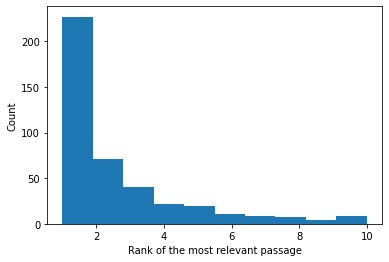

In [ ]:
evaluate_results(I, gold_para)

#### 2. Using DPRReader

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.6 MB/s 
     |████████████████████████████████| 7.6 MB 32.4 MB/s 
     |████████████████████████████████| 182 kB 58.6 MB/s 


In [ ]:
import torch

from transformers import DPRContextEncoder, DPRContextEncoderTokenizer
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer

para_tokenizer = DPRContextEncoderTokenizer.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")
para_model = DPRContextEncoder.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")

ques_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained("facebook/dpr-question_encoder-single-nq-base")
ques_model = DPRQuestionEncoder.from_pretrained("facebook/dpr-question_encoder-single-nq-base")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.


Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/493 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
train_data = load_data()
theme_wise_data = load_theme_wise_data(train_data)

Number of examples = 75056
	Answerable questions = 50126
	Non-Answerable questions = 24930

Examples:
 | Theme  |  Paragraph...  |  Question | Answer_possible | Answer_text | Answer_start
1430 | Frédéric_Chopin  |  Some modern commenta...  |  Who said Chopin's works were modeled after Bach, Beethoven, Schubert and Field? | True | ['Richard Taruskin'] | [543]
2196 | The_Legend_of_Zelda:_Twilight_Princess  |  Twilight Princess ta...  |  Who releases Bulbins from the Realm of Twilight? | False | [] | []

Total 361 themes present.


In [ ]:
paras, ques, gold_para, _ = load_ques_by_theme('Beyoncé', theme_wise_data, answerable_only=True)
# sents, para_id = load_sents_from_para(paras)

Total Questions: 523
Total Paragraphs: 66


In [ ]:
para_embeds = []
for i, para in enumerate(paras):
    para_input_ids = para_tokenizer(para, return_tensors="pt")["input_ids"]
    with torch.no_grad():
        para_embeddings = para_model(para_input_ids).pooler_output
    para_embeds.append(para_embeddings)
    print(f'\r{round(100.*(i+1) / len(paras), 2)} % completed', end='')

p = torch.cat(para_embeds, dim=0)
print(f'\n{p.shape}')

100.0 % completed
torch.Size([66, 768])


In [ ]:
ques_embeds = []
for i, query in enumerate(ques):
    ques_input_ids = ques_tokenizer(query, padding=True, return_tensors="pt")["input_ids"]
    with torch.no_grad():
        ques_embeddings = ques_model(ques_input_ids).pooler_output
    ques_embeds.append(ques_embeddings)
    print(f'\r{round(100.*(i+1) / len(ques), 2)} % completed', end='')

q = torch.cat(ques_embeds, dim=0)
print(f'\n{q.shape}')

In [ ]:
k = 10
D, I = get_k_nearest_neighbours(p, q, k)
# pred_para = sent_id_to_para_id(I, para_id)

Total queries: 523
In top 10 results, number of queries for which -
	Relevant paragraph found: 346 (66 %)
	Relevant paragraph NOT found: 177 (34 %)
Mean Rank for which relevant paragraph found: 3.58



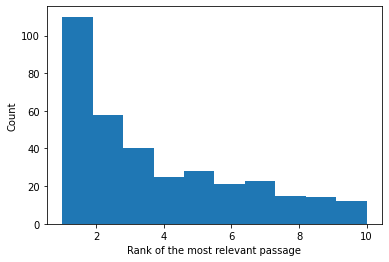

In [ ]:
evaluate_results(I, gold_para)

##### Using DPR Reader model itself for prediction (Incomplete)

In [ ]:
from transformers import DPRReader, DPRReaderTokenizer
import torch

tokenizer = DPRReaderTokenizer.from_pretrained("facebook/dpr-reader-single-nq-base")
model = DPRReader.from_pretrained("facebook/dpr-reader-single-nq-base")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/484 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRReaderTokenizer'.


Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-reader-single-nq-base were not used when initializing DPRReader: ['span_predictor.encoder.bert_model.pooler.dense.weight', 'span_predictor.encoder.bert_model.pooler.dense.bias']
- This IS expected if you are initializing DPRReader from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRReader from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
query_list = theme_wise_data['Beyoncé']['ques']
para_list = theme_wise_data['Beyoncé']['para']

In [ ]:
encoded_inputs = tokenizer(
    questions = query_list[0],
    texts = para_list,
    return_tensors="pt",
)
encoded_inputs

{'input_ids': tensor([[  101,  2043,  2106, 20773,  2681, 10461,  1005,  1055,  2775,  1998,
          2468,  1037,  3948,  3220,  1029,   102,   100,   100,   100,   100,
           100,   100,   100,   100,   100,   100,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]])}

In [ ]:
with torch.no_grad():
    outputs = model(**encoded_inputs)
outputs.relevance_logits

tensor([-9.0228])

#### 3. Using DensePhrases for phrase/passage retrieval (Incomplete)

In [ ]:
train_data = load_data()

Number of examples = 75056
	Answerable questions = 50126
	Non-Answerable questions = 24930

Examples:
Theme  |  Paragraph...  |  Question | Answer_possible | Answer_text | Answer_start
Frédéric_Chopin  |  Some modern commenta...  |  Who said Chopin's works were modeled after Bach, Beethoven, Schubert and Field? | True | ['Richard Taruskin'] | [543]
The_Legend_of_Zelda:_Twilight_Princess  |  Twilight Princess ta...  |  Who releases Bulbins from the Realm of Twilight? | False | [] | []


In [ ]:
!git clone https://www.github.com/nvidia/apex.git
%cd apex
!git checkout remotes/origin/22.04-dev
!python setup.py install
%cd ..

In [ ]:
!git clone -b v1.0.0 https://github.com/princeton-nlp/DensePhrases.git
%cd DensePhrases
!pip install -r requirements.txt
!python setup.py develop

In [ ]:
import json

# Data to be written
articles = {"data": []}
for theme in theme_wise_data:
    content = {
        "title": theme,
        "paragraphs": []
    }
    for para in theme_wise_data[theme]["paragraphs"]:
        content["paragraphs"].append(para)
    articles["data"].append(content)

# Serializing json
json_object = json.dumps(articles, indent=4)

# Writing to articles.json
with open("articles.json", "w") as outfile:
    outfile.write(json_object)

In [ ]:
questions = {
    "data": [
        {
            "id": "1",
            "question": "Who said Chopin's works were modeled after Bach, Beethoven, Schubert and Field?",
            "answers": ["Richard Taruskin", "Country singer Kevin Skinner"]
        },
        {
            "id": "2",
            "question": "What role did Beyoncé have in Destiny's Child?",
            "answers": ["lead singer"]
        },
        {
            "id": "3",
            "question": "What percentage of Dhulbahante men married women of the Majerteen or Ogaden?",
            "answers": ["4.3%"]
        }
    ]
}

# Serializing json
json_object = json.dumps(questions, indent=4)

# Writing to articles.json
with open("questions.json", "w") as outfile:
    outfile.write(json_object)

In [ ]:
!wget https://nlp.cs.princeton.edu/projects/densephrases/outputs.tar.gz
!tar -xvf '/content/DensePhrases/outputs.tar.gz'

In [ ]:
!python generate_phrase_vecs.py \
    --model_type bert \
    --pretrained_name_or_path SpanBERT/spanbert-base-cased \
    --data_dir ./ \
    --cache_dir ./cache \
    --predict_file examples/create-custom-index/articles.json \
    --do_dump \
    --max_seq_length 512 \
    --doc_stride 500 \
    --fp16 \
    --filter_threshold -2.0 \
    --append_title \
    --load_dir ./outputs/densephrases-multi \
    --output_dir ./outputs/densephrases-multi_sample

Traceback (most recent call last):
  File "generate_phrase_vecs.py", line 231, in <module>
    main()
  File "generate_phrase_vecs.py", line 227, in main
    dump_phrases(args, model, tokenizer, filter_only=args.filter_only)
  File "generate_phrase_vecs.py", line 79, in dump_phrases
    dataset, examples, features = load_and_cache_examples(
  File "/content/DensePhrases/densephrases/utils/squad_utils.py", line 1245, in load_and_cache_examples
    examples = processor.get_dev_examples(args.data_dir, filename=args.predict_file, draft=args.draft,
  File "/content/DensePhrases/densephrases/utils/squad_utils.py", line 809, in get_dev_examples
    return self._create_examples(input_data, "dev", draft, context_only=context_only, args=args)
  File "/content/DensePhrases/densephrases/utils/squad_utils.py", line 822, in _create_examples
    truecase = TrueCaser(os.path.join(os.environ['DATA_DIR'], args.truecase_path))
  File "/content/DensePhrases/densephrases/utils/squad_utils.py", line 1460, i

In [ ]:
import os
os.environ['DATA_DIR'] = "/content/DensePhrases"